# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> EE 046746 - Technion - Computer Vision


## Homework 2 - Image Classification and Foundation Models
---

### <a style='color:red'> Due Date: 18.12.2024 </a>

### <img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines
---
#### READ THIS CAREFULLY
* Submission only in **pairs**.
* **No handwritten submissions**.
* You can choose your working environment:
    * You can work in a `Jupyter Notebook`, locally with <a href="https://www.anaconda.com/distribution/">Anaconda</a> or online on <a href="https://colab.research.google.com/">Google Colab</a>
  * **Important**: Colab also supports running code on GPU, so if you don't have one, Colab is the way to go. To enable GPU on Colab, in the menu: `Runtime` $\rightarrow$  `Change Runtime Type` $\rightarrow$`GPU`.
    * You can work in a Python IDE such as <a href="https://www.jetbrains.com/pycharm/">PyCharm</a> or <a href="https://code.visualstudio.com/">Visual Studio Code</a>.
        * Both also allow opening/editing Jupyter Notebooks.

* Make sure you submit your exercise according to the requirements in the <a href="https://moodle.technion.ac.il/pluginfile.php/1823033/mod_resource/content/2/Homework%20guidelines.pdf">"Homework submission guidelines"</a> file that appears in the course website (Moodle). 
* **The code should run both on CPU and GPU without manual modifications**, require no special preparation and run on every computer.
* **DON'T** submit the CIFAR-10 dataset in your submission, we have a local copy of it.
* **DON'T** submit the trained networks, but make sure to document every result you get.
* Be precise, we expect on point answers.
* Submission on the course website (Moodle).
* **Parts 1-2 are a bonus, part 3 on CLIP is mandatory.**

### <img src="https://img.icons8.com/dusk/64/000000/python.png" style="height:50px;display:inline"> Python Libraries
---

* `numpy`
* `matplotlib`
* `pytorch` (and `torchvision`)
* `opencv` (or `scikit-image`)
* `scikit-learn`
* Anything else you need (`PIL`, `os`, `pandas`, `csv`, `json`,...)

In [1]:
### imports
import os
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import scipy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import PIL
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
### general device and path for universal use

if os.getcwd().split('/')[-1] == 'code':
    data_path = '../data/'
else:
    data_path = 'data/'

if torch.cuda.is_available():
    device = torch.device('cuda')
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: mps


### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Tasks
---
* In all tasks, you should document your process and results in a report file (which will be saved as `.pdf`). 
* You can reference your code in the report file, but no need for actual code in this file, the code is submitted in a seprate folder as explained above.

#### Part 1 - Classic Classifier - Bonus
---
In this part we are going to examine the performance of a classical classifier over images from the **Canadian Institute For Advanced Research (CIFAR-10)**  Dataset. 

* The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.
  * There is also CIFAR-100, with 100 classes.
* The classes are completely mutually exclusive. For example, there is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.
* <a href="https://www.cs.toronto.edu/~kriz/cifar.html">Official Site</a>


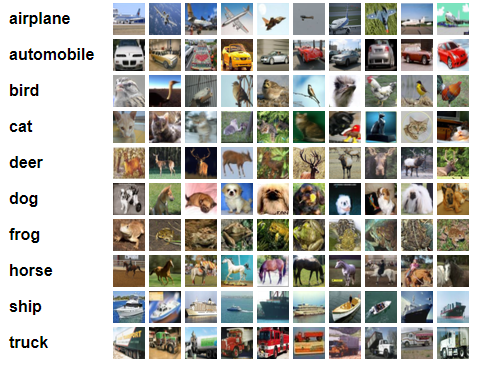


1. Load the CIFAR-10 training and test set with PyTorch (<a href="https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10">read more here</a>). Display 5 images from the training set with their labels as title.

In [6]:
## load CIFAR data:

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Train set from data folder
trainset = datasets.CIFAR10(root=data_path, train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)

# Test set from data folder
testset = datasets.CIFAR10(root=data_path, train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

# Define labels for CIFAR-10
label_dict = {}
for i, label in enumerate(trainloader.dataset.classes):
    label_dict[i] = label

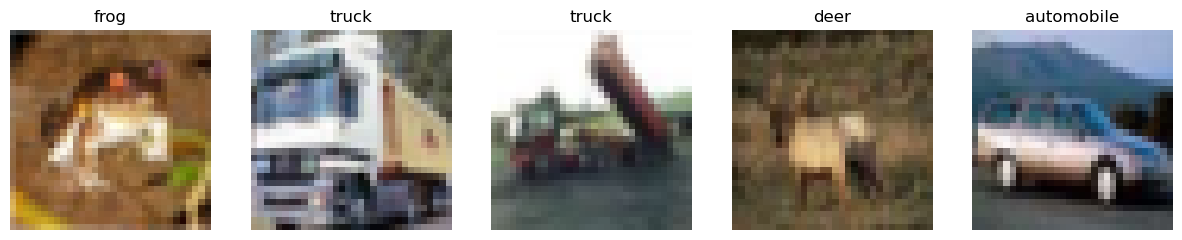

In [7]:
## Display images from train set

# Collect sample
data_sample_img = trainloader.dataset.data[:5]
data_sample_label = trainloader.dataset.targets[:5]

# Display
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(data_sample_img[i])
    label_name = label_dict[data_sample_label[i]]
    ax[i].set_title(label_name)
    ax[i].axis('off')

2. Build a K-Nearest Neighbors (K-NN) classifier (hint: `sklearn.neighbors.KNeighborsClassifier`), with `n_neighbors=10`, to classify CIFAR-10: Load 10,000 samples from the training set and train the model. 

  **Note**: The model's input dimension should be : `(n_samples, n_features)`, Thus you need to convert each color channel to row representation and then concatenate the 3 color channels.

In [5]:
### Build KNN classifier
k = 10
n_samples = 10000

# Load CIFAR-10 data
X_train = trainloader.dataset.data[:n_samples].reshape(n_samples, -1) # concatenate each image to a row
y_train = trainloader.dataset.targets[:n_samples]

# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

3. Load 1,000 samples from CIFAR-10 test set and check the performance of the K-NN classifier over these samples. What is the accuracy obtained? View the results using a confusion matrix(see <a href="https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62">here</a> for more information)

In [6]:
### Evaluate KNN classifier

# Load test samples
n_test_samples = 1000
X_test = testloader.dataset.data[:n_test_samples].reshape(n_test_samples, -1)
y_test = testloader.dataset.targets[:n_test_samples]

# Predict
y_pred = knn.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc}')

Accuracy: 0.288


The accuracy obtained using a KNN classifier with k=10 is 0.288.

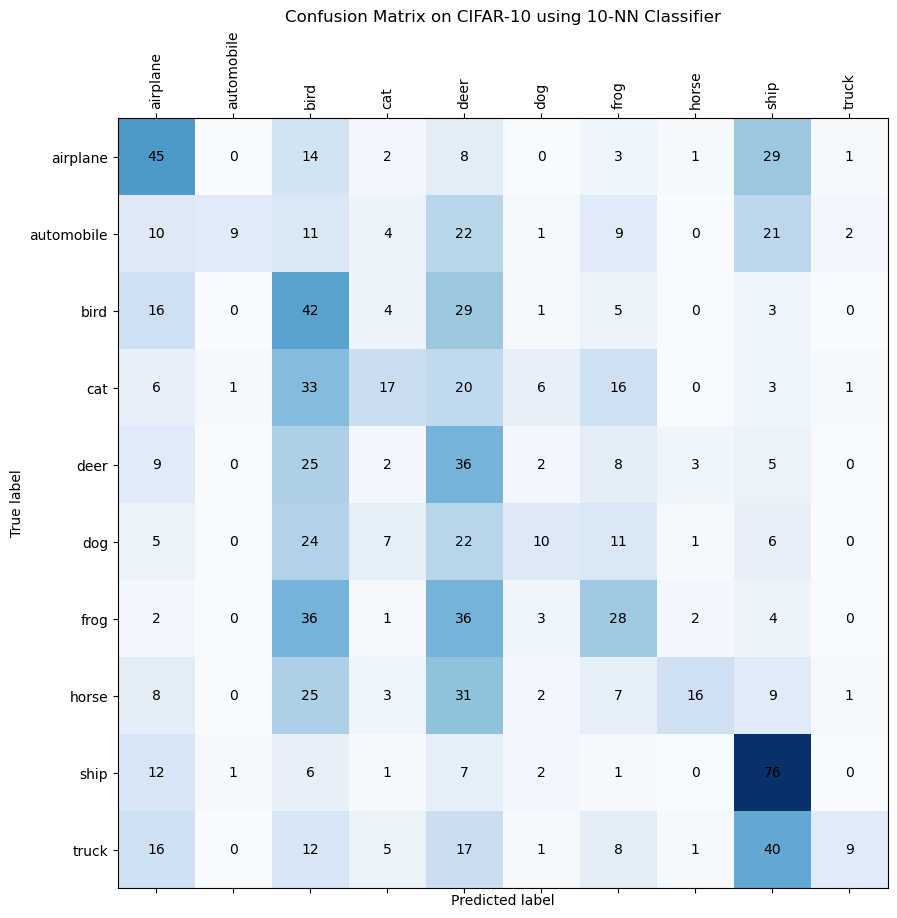

In [7]:
### Confusion matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.title('Confusion Matrix on CIFAR-10 using 10-NN Classifier')
ax.matshow(cm, cmap='Blues')
for i in range(10):
    for j in range(10):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.xlabel('Predicted label')
plt.xticks(range(10), [label_dict[i] for i in range(10)], rotation=90)
plt.ylabel('True label')
plt.yticks(range(10), [label_dict[i] for i in range(10)])
plt.show()

4. Compare the model's accuracy for different number of neighbors ($1 \leq K \leq 30$ ). Display the results in a graph of accuracy as function of $K$.

100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


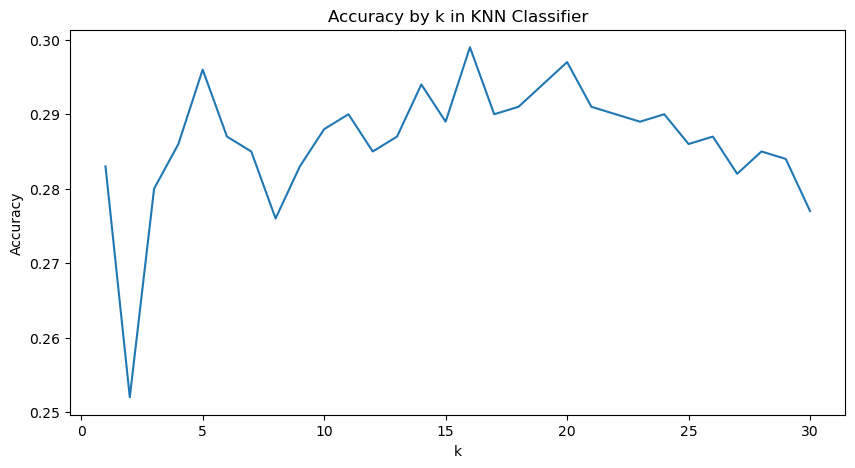

In [8]:
# Define k range:
k_list = range(1, 31)
acc_list_by_k = []

# Train and predict for each k
for k in tqdm(k_list):
    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predict
    y_pred = knn.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    acc_list_by_k.append(acc)

# Plot accuracy by k
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.title('Accuracy by k in KNN Classifier')
plt.plot(k_list, acc_list_by_k)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

We can see that the accuracy is pretty low (0.25-0.3) for all k values in the range.

#### Part 2 - Design and Build a CNN Classifier - Bonus
---
In this part you are going to design a deep convolutional neural network to classify CIFAR-10 dataset. 

1. Use the CNN from tutorials 3-4 , provided in the next block(`SvhnCnn()`) and train it on the CIFAR-10 dataset (**keep the architecture the same**) for the same number of **epochs** with the same learning rate (try to keep the batch size the same, but if you get memory errors, you can reduce it). What is the accuracy on the test set? What classes are most confusing for this model?
    * Your test accuracy from this section will be your **baseline** accuracy for sections 2-3.

Code from tutorial:

In [8]:
# define pre-processing steps on the images
# also called "data augementation" (only done for the train set)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=63. / 255., saturation=[0.5, 1.5], contrast=[0.2, 1.8]),
    transforms.ToTensor(),  # (almost) Always use this!
    # SVHN dataset's:     Mean - R    Mean - G   Mean - B       STD - R     STD - G     STD - B
    transforms.Normalize((0.4376821, 0.4437697, 0.47280442), (0.19803012, 0.20101562, 0.19703614)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4376821, 0.4437697, 0.47280442), (0.19803012, 0.20101562, 0.19703614)),
])

In [9]:
class SvhnCNN(nn.Module):
    """CNN for the SVHN Datset"""

    def __init__(self):
        """CNN Builder."""
        super(SvhnCNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            # What are the dims after this layer? 
            # How many weights?
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),  # <- Why is this here?

            # Modified Conv Layer block 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # As we go deeper - use more channels!
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8192, 512),  # <- How do we know it's 8192? Why 512 later?
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)  # <- Why 10 here?
        )

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x

Training the CNN:

In [23]:
def train_svhn(model, dataset, criterion, lr, batch_size, epochs):
    """Train the CNN on the SVHN dataset."""

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            # inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # forward + backward + optimize
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # log statistics
            running_loss += loss.item()
            if i % 100 == 99:
                print(f'[{epoch + 1}, {i+1}]: {running_loss / len(trainloader)}')
            running_loss = 0.0

In [21]:
# hyper-parameters from tutorial
batch_size = 128
learning_rate = 1e-4
epochs = 20
criterion = nn.CrossEntropyLoss()

In [ ]:
svhn_model = SvhnCNN().to(device)
train_svhn(svhn_model, trainset, criterion=criterion, lr=learning_rate, batch_size=batch_size, epochs=epochs)

# save trained model
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(svhn_model.state_dict(), 'models/baseline_model.pth')

[1, 100]: 0.0041581291676787155
[1, 200]: 0.0041298216870983544
[1, 300]: 0.003296654547571831
[2, 100]: 0.0032407274026699994
[2, 200]: 0.003250956230456262
[2, 300]: 0.00270147671175125
[3, 100]: 0.0028994022427922318
[3, 200]: 0.0024254169610455215
[3, 300]: 0.0025254102314219754
[4, 100]: 0.0026255626507732267
[4, 200]: 0.0021823717810003957
[4, 300]: 0.0026041510160012015
[5, 100]: 0.0020544842990767925
[5, 200]: 0.002158527484025492
[5, 300]: 0.0019538628170862223
[6, 100]: 0.0019312127471884802
[6, 200]: 0.0024595361231538036
[6, 300]: 0.002397929920869715
[7, 100]: 0.0017726171352064517
[7, 200]: 0.0013855326815944194
[7, 300]: 0.0017978934680714326
[8, 100]: 0.0017108871503864103
[8, 200]: 0.0015035575003270298
[8, 300]: 0.0017095121276348142
[9, 100]: 0.0012540141944690129
[9, 200]: 0.0012887342811545447
[9, 300]: 0.0021622955341778142
[10, 100]: 0.0015728313599706
[10, 200]: 0.001585656419739394
[10, 300]: 0.001496880103255172
[11, 100]: 0.0009993549503023971
[11, 200]: 0.00

Evaluating the CNN:

In [25]:
### from tutorial:
def calculate_accuracy(model, dataloader):
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([10,10], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1 

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

In [28]:
train_base_model_accuracy, train_base_model_confusion_matrix = calculate_accuracy(svhn_model, trainloader)
print(f'Training accuracy: {train_base_model_accuracy}%')

Training accuracy: 96.576%


Baseline accuracy on test: 78.05%


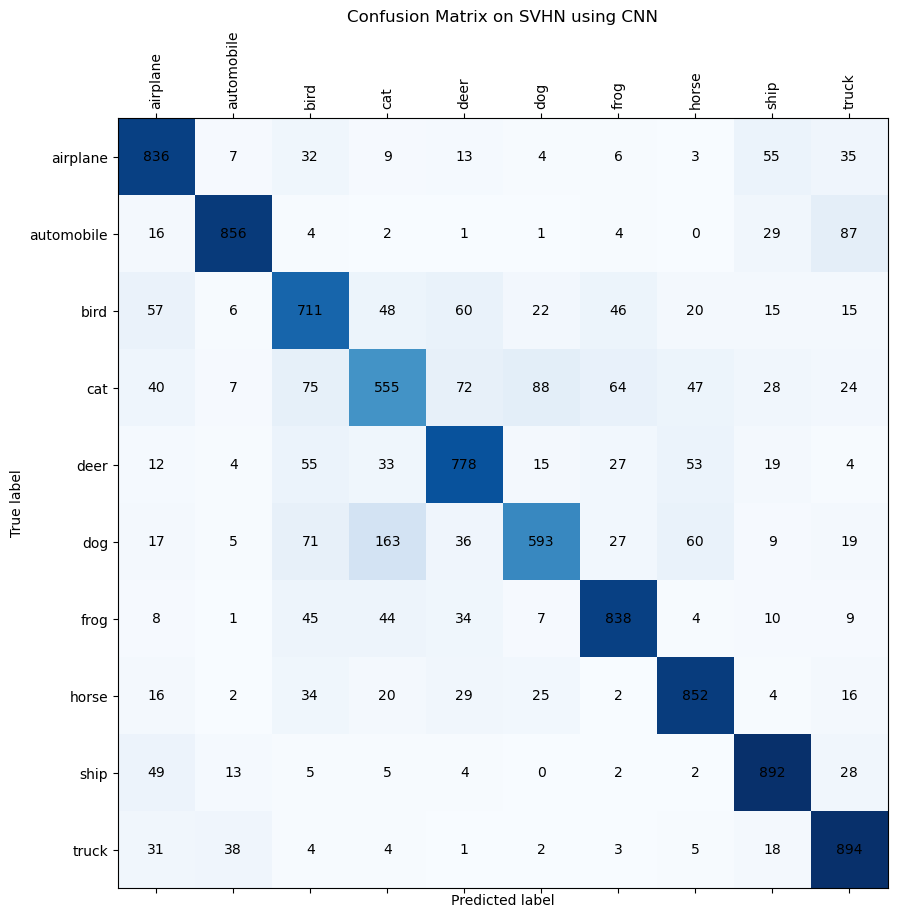

In [ ]:
base_model_acc, base_model_cm = calculate_accuracy(svhn_model, testloader)

# Print accuracy
print(f'Baseline accuracy on test: {base_model_acc:.2f}%')

# Display confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.title('Confusion Matrix on SVHN using CNN')
ax.matshow(base_model_cm, cmap='Blues')
for i in range(10):
    for j in range(10):
        ax.text(j, i, base_model_cm[i, j], ha='center', va='center', color='black')
plt.xlabel('Predicted label')
plt.xticks(range(10), [label_dict[i] for i in range(10)], rotation=90)
plt.ylabel('True label')
plt.yticks(range(10), [label_dict[i] for i in range(10)])
plt.show()

The model performs well on all classes. The most confusion can be seen between the cat and dog classes.

2. Design your own Convolutional Neural Network (CNN) to classify CIFAR-10. You can modify the network from section 1,but **you must get a better result than your baseline accuracy from section 1**.
    * You **need** to use one of the following in your CNN - Residual block, activation function <a href="https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html">PReLU</a>, activation function Leaky ReLU, Group Normalization, <a href="https://towardsdatascience.com/intuitive-explanation-of-exponential-moving-average-2eb9693ea4dc">Exponential moving average (EMA)</a>.
      Explain the technique you have chosen.
    * Describe the chosen architecture, how many layers? What activations did you choose? What are the filter sizes? Did you use fully-connected layers (if you did, explain their sizes)?
    * What is the input dimension? What is the output dimension?
    * Calculate the number of parameters (weights) in the network.

  **Note:** 
    * The new network should perform better over the same task (i.e. using the same data with the same hyper-parameters. Change only the network architecture).
    * Students who reach the highest accuracy over the test set will receive **5 bonus points** for this exercise.


In [42]:
class MySvhnCNN(nn.Module):
    """CNN for the SVHN Datset"""

    def __init__(self):
        """CNN Builder."""
        super(MySvhnCNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.2), # new

            # Conv Layer block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.2), # increase prob

            # Modified Conv Layer block 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), # new
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2), # increase prob
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.2), # increase prob
            nn.Linear(8192, 512),  # <- How do we know it's 8192? Why 512 later?
            nn.BatchNorm1d(512), # new
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2), # new
            nn.Linear(512, 10)  # <- Why 10 here?
        )

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x

3. Train the classifier (preferably on a **GPU - use Colab for this part** if you don't have a GPU).
    * Describe the hyper-parameters of the model (batch size, epochs, learning rate....). How did you tune your model? Did you use a validation set to tune the model? (<a href="https://gist.github.com/MattKleinsmith/5226a94bad5dd12ed0b871aed98cb123">Separating to train/validation/test in PyTorch</a>)
    * What is the final accuracy on the test set?

In [ ]:
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import KFold
from collections import defaultdict

class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_svhn_kfold(model, dataset, criterion, lr, batch_size, epochs, k_folds=5):
    # Initialize K-fold cross validation
    kfold = KFold(n_splits=k_folds, shuffle=True)

    # Create dataset indices
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(indices)):
        print(f'FOLD {fold + 1}/{k_folds}')
        
        # Sample data for this fold using indices
        train_sampler = SubsetRandomSampler(train_ids)
        val_sampler = SubsetRandomSampler(val_ids)
        
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)
        
        # Initialize optimizer and scheduler
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
        early_stopping = EarlyStopping(patience=5)
        
        # Training loop for this fold
        for epoch in range(epochs):
            ### Training phase
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                train_total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()
            
            ### Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()
            
            # Calculate average losses and accuracies
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            train_accuracy = 100. * train_correct / train_total
            val_accuracy = 100. * val_correct / val_total
            
            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
            print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
            
            # Early stopping
            early_stopping(avg_val_loss)
            if early_stopping.early_stop:
                print("Early stopping triggered")
                break
        
        print(f'Fold {fold + 1} complete')
    

In [ ]:
# my hyper-parameters
batch_size = 128
learning_rate = 1e-4
epochs = 20
criterion = nn.CrossEntropyLoss()

# train model
my_svhn_model = MySvhnCNN().to(device)
train_svhn_kfold(my_svhn_model, trainset, criterion=criterion, lr=learning_rate, batch_size=batch_size, epochs=epochs, k_folds=5)

FOLD 1/5
Epoch 1/20:
Train Loss: 1.6687, Train Acc: 39.59%
Val Loss: 1.3310, Val Acc: 51.70%
Epoch 2/20:
Train Loss: 1.3452, Train Acc: 51.75%
Val Loss: 1.1579, Val Acc: 58.17%
Epoch 3/20:
Train Loss: 1.1879, Train Acc: 57.54%
Val Loss: 1.0489, Val Acc: 62.74%
Epoch 4/20:
Train Loss: 1.0701, Train Acc: 62.04%
Val Loss: 0.9715, Val Acc: 65.59%
Epoch 5/20:
Train Loss: 0.9904, Train Acc: 65.08%
Val Loss: 0.9053, Val Acc: 68.16%
Epoch 6/20:
Train Loss: 0.9166, Train Acc: 67.76%
Val Loss: 0.8639, Val Acc: 69.47%
Epoch 7/20:
Train Loss: 0.8477, Train Acc: 70.33%
Val Loss: 0.8202, Val Acc: 71.74%
Epoch 8/20:
Train Loss: 0.8011, Train Acc: 72.05%
Val Loss: 0.7967, Val Acc: 72.34%
Epoch 9/20:
Train Loss: 0.7390, Train Acc: 74.28%
Val Loss: 0.7657, Val Acc: 72.94%
Epoch 10/20:
Train Loss: 0.7013, Train Acc: 75.44%
Val Loss: 0.7608, Val Acc: 73.82%
Epoch 11/20:
Train Loss: 0.6585, Train Acc: 77.11%
Val Loss: 0.7520, Val Acc: 74.41%
Epoch 12/20:
Train Loss: 0.6171, Train Acc: 78.45%
Val Loss: 0.73

NameError: name 'fold_results' is not defined

In [48]:
# save trained model
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(my_svhn_model.state_dict(), 'models/my_model_cv.pth')

In [50]:
train_my_model_accuracy, train_my_model_confusion_matrix = calculate_accuracy(my_svhn_model, trainloader)
print(f'Training accuracy: {train_my_model_accuracy}%')

Training accuracy: 99.822%


In [ ]:
my_model_acc, my_model_cm = calculate_accuracy(my_svhn_model, testloader)
print(f'Testing accuracy: {my_model_acc:.2f}%')


Testing accuracy: 79.29%


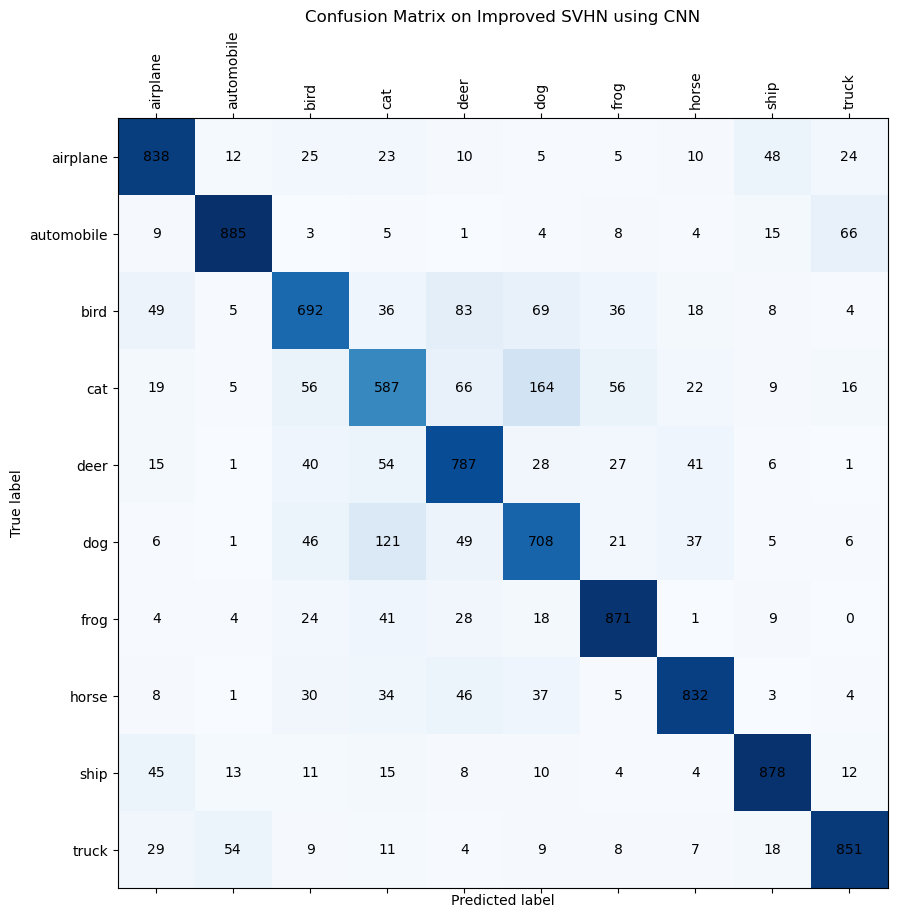

In [49]:
# Display confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.title('Confusion Matrix on Improved SVHN using CNN')
ax.matshow(my_model_cm, cmap='Blues')
for i in range(10):
    for j in range(10):
        ax.text(j, i, my_model_cm[i, j], ha='center', va='center', color='black')
plt.xlabel('Predicted label')
plt.xticks(range(10), [label_dict[i] for i in range(10)], rotation=90)
plt.ylabel('True label')
plt.yticks(range(10), [label_dict[i] for i in range(10)])
plt.show()

#### Part 3 - Foundation Models - Mandatory
---
As we've seen, CNNs are very powerful models for image classification, However, they also require a lot of training data and a lot of training time. In this part we will use CLIP, a new model from OpenAI, which is a foundation model for vision and language. CLIP is a neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similarly it can be asked to predict the most relevant image, given some text. CLIP has been trained on 400 million (image, text) pairs ([read more here](https://openai.com/blog/clip/)).

The following exercise can be done both locally on cpu, and in GPU. consider the following: if it is done on CPU, it will take a long time to run, and that's ok.

We'll first start by installing the CLIP model and the necessary packages:

In [ ]:
%pip install git+https://github.com/openai/CLIP.git
%pip install seaborn

Now that we've installed the model, we can load it and use it to classify images. We'll start by loading the model.

In [ ]:
import clip

def load_image(image_path):
    """ Load an image from a file path. """
    image = Image.open(image_path).convert("RGB")
    return image

#load the model
model, preprocess = clip.load("ViT-L/14@336px", device=device)


you can find documentation for this model in the following github: https://github.com/openai/CLIP

1. Load the provided images under the directory data/clip_images. compute their embeddings, and project them to the embedding space using T-SNE(An algorithm for dimensionality reduction)(<a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html">read more here</a>) . Plot the images in the embedding space. Do you see any clusters? What do you think these clusters represent?

In [29]:
clip_images_path = data_path + "clip_images/"

clip_image_cats = [load_image(clip_images_path + "cats/" + img) for img in os.listdir(clip_images_path+ "cats")]
clip_image_dogs = [load_image(clip_images_path + "dogs/" + img) for img in os.listdir(clip_images_path+ "dogs")]

clip_labels = ["cat"]*len(clip_image_cats) + ["dog"]*len(clip_image_dogs)
clip_images = clip_image_cats + clip_image_dogs
print(len(clip_images))

# preprocess the images
clip_images = [preprocess(img).unsqueeze(0).to(device) for img in clip_images]

100


In [30]:
# Embed the images
clip_image_embeddings = []
with torch.no_grad():
    for img in clip_images:
        image_features = model.encode_image(img)
        clip_image_embeddings.append(image_features)
clip_image_embeddings = torch.stack(clip_image_embeddings)

print(clip_image_embeddings.shape)

torch.Size([100, 1, 768])


In [31]:
# reshape to 100x768:
clip_image_embeddings = clip_image_embeddings.view(100, 768)

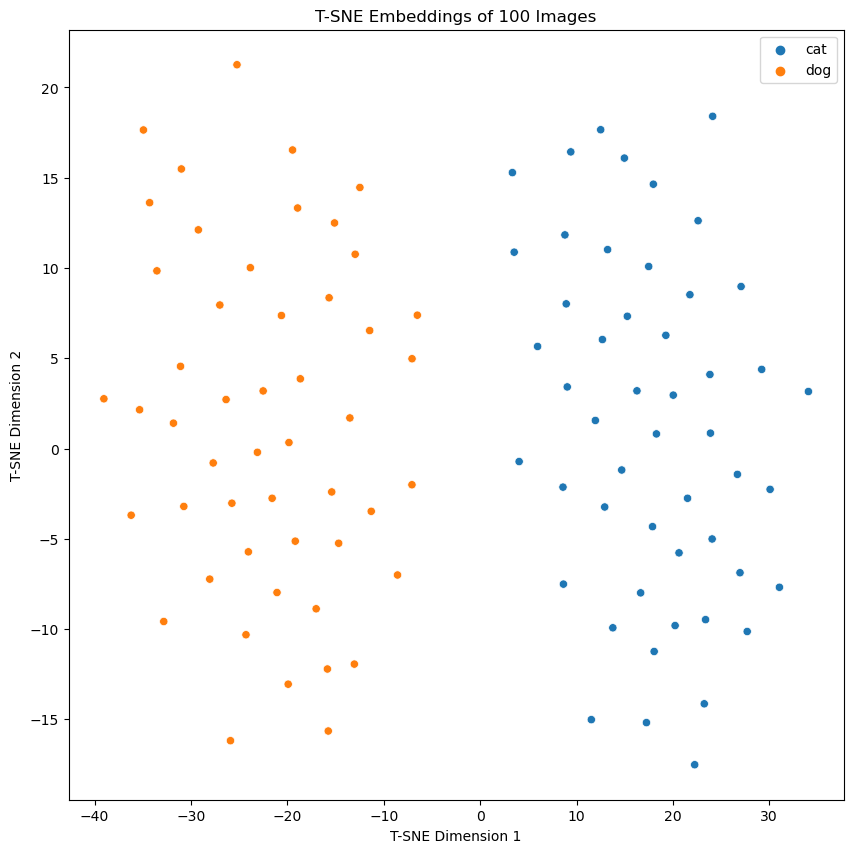

In [32]:
# Project to T-SNE
from sklearn.manifold import TSNE
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(18)
np.random.seed(18)

# Perform T-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=500)
tsne_embeddings = tsne.fit_transform(clip_image_embeddings.cpu().detach().numpy())

# Plot the T-SNE embedding space
plt.figure(figsize=(10, 10))
plt.title('T-SNE Embeddings of 100 Images')
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=clip_labels, palette='tab10')
plt.xlabel('T-SNE Dimension 1')
plt.ylabel('T-SNE Dimension 2')
plt.show()

We can see 2 very clear clusters, divided by the approximate $x=0$ line. Based on the nature of the data used and our knowledge on the data CLIP was trained on, it is logical to guess the model succeeded in separating the 'dogs' and 'cats' image embeddings within the space. We then add hue to the scatter plot based on the labels and see we were correct, and the model separated well between cats and dogs.

2. Load the provided image under the directory data/clip_images, named alfie.jpeg, and display it. Compute its embeddings using the CLIP model. find the top 5 most similar images (according to the cosine similarity between their embeddings). Display the result in as a row of images. Do you think the results make sense? Why?

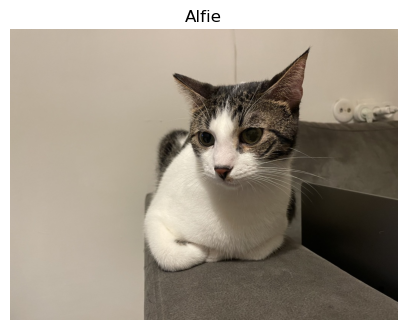

In [15]:
# Load Alfie image
alfie_path = data_path + "clip_images/alfie.jpeg"
alfie = load_image(alfie_path)

# Display image
plt.figure(figsize=(5, 5))
plt.title('Alfie')
plt.imshow(alfie)
plt.axis('off')
plt.show()

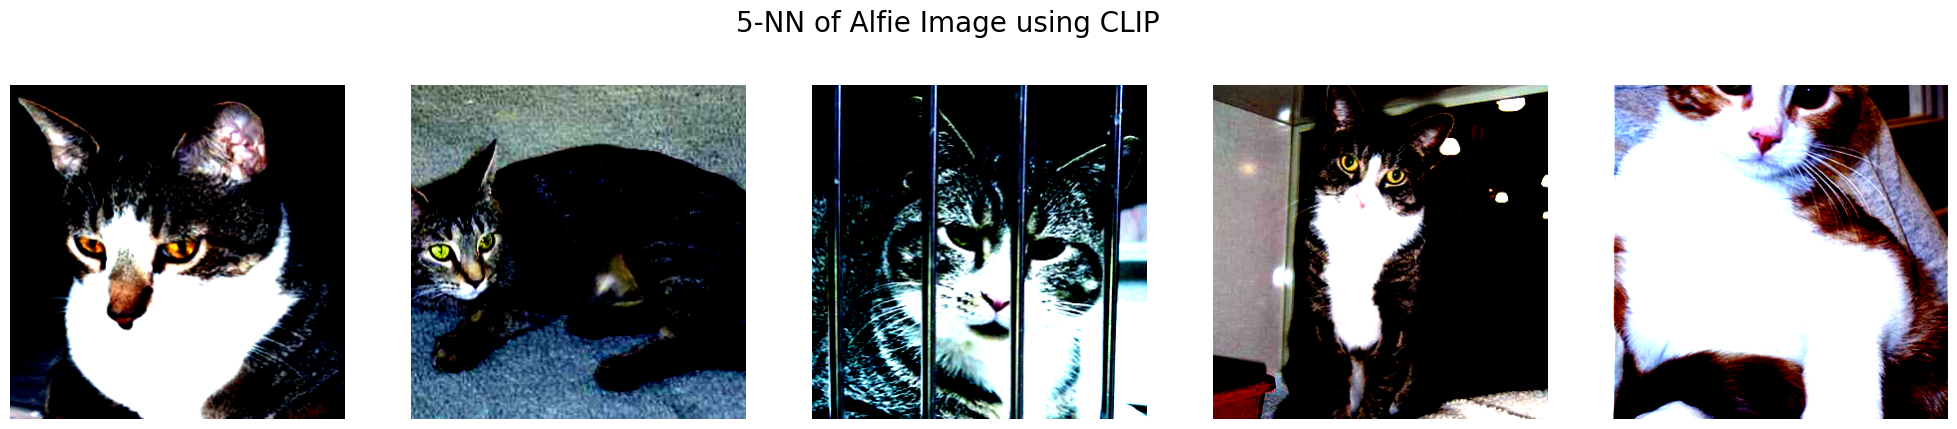

In [17]:
# Compute embedding:
alfie_input = preprocess(alfie).unsqueeze(0).to(device)
alfie_embedding = model.encode_image(alfie_input)

# Find 5-NN:
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(clip_image_embeddings.cpu().detach().numpy(), np.arange(100))

# Predict:
alfie_embedding = alfie_embedding.cpu().detach().numpy()
alfie_pred = knn.kneighbors(alfie_embedding, return_distance=False)

# Display 5-NN:
plt.figure(figsize=(25, 5))
plt.suptitle('5-NN of Alfie Image using CLIP', fontsize=20)
for i, idx in enumerate(alfie_pred[0]):
    plt.subplot(1, 5, i+1)
    img = clip_images[idx].cpu().numpy().squeeze().transpose(1, 2, 0).clip(0, 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

*Answer:*

First, the results are all cat images and no dog images, which matches our expected result. Second, we notice that most of the cats have a white coloring around the same location as Alfie, and some have a general gray-black coloring as well. This is a good indication that the model is able to understand the context of the image and not just the image itself.

Now that we've seen the power of CLIP Embeddings, lets try and use the textual embeddings to classify images.

3. in the data provided with the exercise, look at the directory data/clip_images/test. 

    3.1 Parse the labels in the path data/clip_images/test/labels.txt
    
    3.2 Read the images in data/clip_images/test
    
    3.3 classify each image to one of the classes, Dogs and Cats
    
    3.4 Compute the accuracy of the classification, given the labels in labels.txt, and plot a confusion matrix.

in this exercise, you must use the CLIP Textual embeddings, as shown in the tutorial.  What are the strengths of this approach? What are the weaknesses? If the folder also contained images that are not cats, nor dogs,  how would you classify those images? note - the wanted class in this case would be "Other".

In [ ]:
## 3.1: Load the text data into a dictionary by image
text_label_dict = {}
with open(data_path + 'clip_images/test/labels.txt', 'r') as file:
    for i, line in enumerate(file):
        key = line.split(':')[0]
        value = line.split(':')[1].strip()
        text_label_dict[key] = value

In [ ]:
## 3.2: Load the test images:
test_image_dir = data_path + 'clip_images/test/'

test_image_files = []
for img in os.listdir(test_image_dir):
    if img.endswith('.jpg'):
        test_image_files.append(test_image_dir + img)

print(f'Number of test images: {len(test_image_files)}')

Number of test images: 200


In [ ]:
## 3.3: Classify the test images using CLIP

test_preds = {}

with torch.no_grad():
    # Preprocess and encode images
    image_inputs = torch.stack([preprocess(load_image(img)).to(device) for img in test_image_files])
    image_features = model.encode_image(image_inputs) 

    # Preprocess and encode text
    titles = []
    for img in test_image_files:
        img_name = img.split('/')[-1]
        title = "A photo of a " + text_label_dict[img_name]
        titles.append(title)

    text_inputs = clip.tokenize(titles).to(device)
    text_features = model.encode_text(text_inputs)

    # Calculate similarities and return softmax probabilities
    similarity = (100 * image_features @ text_features.T).softmax(dim=-1)

    # Get top-1 prediction
    top1_prob, top1_label = similarity.topk(1)

In [69]:
## 3.4: Compute accuracy
true_labels = [1 if label == 'dog' else 0 for label in list(text_label_dict.values())]
correct = np.sum(top1_label.cpu().numpy() == true_labels)
accuracy = correct / len(test_image_files)
print(f'Accuracy: {accuracy}')

Accuracy: 0.26


4. Given the image under the path B, write a function that given an image of cats, returns the number of how many cats are in the image